# Имитационное обучение

***
Задача будет заключаться в том, чтобы провести эксперименты с имитационным обучением: посмотреть, что такое клонирование поведения и разобраться с алгоритмом DAgger.
Вместо человека-эксперта демонстрации будут даваться специальной предобученной "экспертной" стартегией. Ваша задача будет заключаться в реализации алгоритма клонирования и алгоритма DAgger, сравнения их произвоодительости на нескольких простых задачах управления из пакета OpenAI Gym. 



## Необходимые библиотеки:
### 1. __TensorFlow:__
Инструкции-напоминания по установке здесь - https://www.tensorflow.org/get_started/os_setup. Использование GPU необязательно.
### 2. __OpenAI Gym:__  
Напоминание-инструкции по OpenAI Gym - https://gym.openai.com/docs. Используйте версию 0.10.5.
### 3. __MuJoCo:__
Будет использоваться набор симуляционных сред MuJoCo,  версии 1.50 с http://mujoco.org/,  и версию  1.50.1.56  с https://github.com/openai/mujoco-py/. Для активации доступа -  https://www.roboti.us/license.html.
***

Импортируем все необходимое:

In [1]:
import os
import pickle
import tensorflow as tf

print("TensorFlow version :", tf.__version__)

import numpy as np
import tf_util
import gym

print("Gym version :", gym.__version__)

import glfw
import load_policy

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython import display

TensorFlow version : 1.13.1
Gym version : 0.12.1


## Собираем статистику
 Генерируем статистику (roll-outs) по заданной экспертной стратегии в 3 шага:
 1. Загружаем стратегию из файла и инициализируем окружение
 2. Начинаем сессию в tensorflow
 3. В рамках сессии собираем данные: до конца эпизода в цикле выбираем экспертное действие, применяем его и сохраняем результаты

In [2]:
# выбираем одно из окружений:

#env_name="Humanoid-v2"
#env_name="Ant-v2"
env_name ="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"

# выбираем файл с экспертной стратегией для конкретной среды /expert file
expert_policy_file = "experts/" + env_name + ".pkl"

# загружеаем стратегию
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

# создаем gym окружение
env = gym.make(env_name)

# функция генерации rollouts, использующая экспертные стратегии
def generate_rollouts(num_rollouts, max_steps, render=False):
    # инициализируем сессию tf
    with tf.Session():
        tf_util.initialize()

        returns = []
        observations = []
        actions = []

        for i in range(num_rollouts):
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0

            while not done:
                # выбираем действие, в зависимости от наблюдения (observation)
                action = policy_fn(obs[None, :])
                # сохраняем сэмпл
                observations.append(obs)
                actions.append(action)
                # применяем действие в среде
                obs, r, done, _ = env.step(action)
                # считаем общее вознаграждение
                totalr += r
                steps += 1
                # визиализируем окружение
                if render == True:
                    env.render()
                if steps >= max_steps:
                    break
            # добавляем итоговое вознаграждение
            returns.append(totalr)

        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations), 'actions': np.array(actions)}

        return expert_data


loading and building expert policy
obs (1, 17) (1, 17)
loaded and built


Тестируем реализованную функцию: num_rollouts=4,max_steps=100,render=True
***
Замечания:
- Если агента не видно, то можно нажать  __Tab__, для перефокусировки камеры
- В ряде случаев jupyter notebook может вылетать, при закрытии окна отрисоки, поэтому данное окно закрывать ненужно 

In [3]:
generate_rollouts(num_rollouts=4, max_steps=100, render=True)


Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Creating window glfw
mean return 281.35935638310417
std of return 14.11089062513489


{'observations': array([[-6.47392497e-03,  3.97765812e-02,  4.15476136e-02, ...,
          1.54680731e-01, -1.54541185e-02,  5.76285256e-02],
        [-4.56349386e-02,  9.92089457e-03, -7.29460818e-04, ...,
          6.98288692e+00, -1.81998860e+00,  4.78584266e-01],
        [-1.03546934e-01, -2.90043192e-03,  1.90217328e-01, ...,
          5.44600240e+00,  1.47118766e+00, -4.74753180e-01],
        ...,
        [ 6.20963063e-02,  2.15772661e-01,  3.43166136e-01, ...,
          7.48398220e+00, -9.74053236e+00, -1.16807886e+01],
        [ 5.06562528e-02,  1.69370818e-01,  3.42492193e-01, ...,
         -2.72292977e+00, -8.56838204e-01,  3.62157228e+00],
        [ 1.77337226e-02,  8.03585593e-02, -2.52360280e-01, ...,
         -7.67168114e+00,  1.08681244e+01,  1.28754001e+01]]),
 'actions': array([[[-0.07227362,  0.66389614, -1.0189767 ,  0.8081571 ,
           0.14994252,  0.1498869 ]],
 
        [[ 0.62958664,  0.4544771 , -0.6295796 ,  0.8692487 ,
           0.01323357, -0.05990108]],


***
## 1. Клонирование поведения
Клонирование поведения (Behavioural cloning, BC) - метод, с помощью которого компьютерная программа обучается воспроизводить действия эксперта (человека). Действия эксперта записываются, а затем эта статистика используется как входные данные для алгоритма обучения. Этот алгоритм в результате формирует последовательность действий, по которым воспроизводится поведение эксперта.

Будем использовать стандартное обучение с учителем и нейронную сеть.

Кроме конструктора, вам нужно дореализовать метод __build_model__ и __train__ класса __BC_Model__:

### Архитектура нейросети:


`input` > `normalization` > `fc1 ~ relu ~ dropout` > `...` > `fcn ~ relu ~ dropout` > `out`, n - число скрытых слоев

* Функция активации ReLu на данный момент используется в большенстве нейросетей, поэтому будет использоватаься и в данной архитектуре
* Dropout будет использоваться в небольшом размере, чтобы не переобучить нейросеть и не слишком замедлять скорость обучения
* В качестве метода оптимизации будет использоваться Adam, так как он был разработан специально для глубоких нейросетей и хорошо зарекоммендовал себя
* Скорость обучения обычно выбирается 1e-3 - 1e-4. В данной реализации будет использоваться 1e-3

In [3]:
from sklearn.utils import shuffle


class BC_Model(object):
    def __init__(self, input_data, output_data, batch_size=64, dropout_rate = 0.2, hid_layer_size = 256, num_of_hid_layers = 3):
        # созданем сессию tf 
        self.sess = tf.Session()
        # входные и выходные данные, а также их размеры (shapes) 
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # расчет мат. ожидания и среднеквадратического отклонения для нормализации
        self.data_mean = input_data.mean(axis=0)
        self.data_std = input_data.std(axis=0)

        # placeholders нейронной сети (input, model output и expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape=self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape=self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder, 
                                                         dropout_rate, hid_layer_size, num_of_hid_layers)

        ### Ваш код здесь - нужно добавить функцию потерь l2_loss (L2 stands for Least Square Errors)
        self.loss = tf.nn.l2_loss(self.output_placeholder_model - self.output_placeholder_expert)

    def build_model(self, input_placeholder, dropout_rate, hid_layer_size, num_of_hid_layers):
        ### Ваш код здесь - нужно реализовать свою архитектуру нейронной сети
        
        # нормализация
        normalized = (input_placeholder - self.data_mean) / self.data_std
        
        # скрытые слои с dropout
        hidden = tf.layers.dense(input_placeholder, hid_layer_size, activation=tf.nn.relu)
        hidden = tf.nn.dropout(hidden, rate=dropout_rate)
    
        for i in np.arange(num_of_hid_layers - 1):
            hidden = tf.layers.dense(hidden, hid_layer_size, activation=tf.nn.relu)
            hidden = tf.nn.dropout(hidden, rate=dropout_rate)
            hidden = tf.layers.dense(hidden, hid_layer_size, activation=tf.nn.relu)
            hidden = tf.nn.dropout(hidden, rate=dropout_rate)
        
        # выходной слой
        x = tf.layers.dense(hidden, self.output_data.shape[1])
        
        return x

    def train(self, epochs=100, train_data=None, test_data=None):
        if train_data is None and test_data is None:
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state=0)
        else:
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        ### Ваш код здесь - используем AdamOptimizer для минимизации функции потерь l2_loss
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(self.loss)
        
        saver = tf.train.Saver()

        # размер батчей
        batch_idxs = len(train_data) // self.batch_size

        # определяем writer()
        writer = tf.summary.FileWriter("exp")
        writer.add_graph(self.sess.graph)

        # инициализируем параметры сети
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
        
        # итерация по эпохам
        print("Training...")
        for epoch in tqdm_notebook(range(epochs)):
            # итерация по каждому батчу
            for idx in range(batch_idxs):
                batch_train = train_data[idx * self.batch_size: (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size: (idx + 1) * self.batch_size]
                
                ### Ваш код здесь - задаем словарь (feed_train) с входными и выходными данными для обучения 
                feed_train = {self.input_placeholder: batch_train, self.output_placeholder_expert: batch_value}
                
                self.sess.run(optimizer, feed_dict=feed_train)

        # сохраняем модель
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        # сэмплируем действие для заданного входа
        output = self.sess.run(self.output_placeholder_model,
                               feed_dict={self.input_placeholder: np.repeat(input[None, :], self.batch_size, axis=0)})
        return output[0]


### Обучем модель на экспертных данных

In [4]:
def generate_data(num_rollouts=20, max_steps=200, render=False):
    ''' генерирование данных '''
    
    data = generate_rollouts(num_rollouts=20, max_steps=200, render=False)
    x = data['observations']
    y = data['actions']
    print('dimension of obs :', x.shape)
    print('dimension of actions :', y.shape)

    # перемешиваем
    x, y = shuffle(x, y)
    return (x, y)

In [24]:
x, y = generate_data()

mean return 710.9909101359906
std of return 34.293250425745924
dimension of obs : (4000, 17)
dimension of actions : (4000, 1, 6)


In [6]:
# создаем объект класса BC_Model и запускаем обучение
cloner = BC_Model(x, y)
cloner.train()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Training...


### Испытываем модель

In [5]:
def test_model(model, num_eval_rollouts = 20):
    ''' Тестирование модели '''
    
    # итерация по числу rollouts
    returns = []
    print("Testing...")
    for i in tqdm_notebook(range(num_eval_rollouts)):
        totalr = 0
        done = False
        obs = env.reset()
        # цикл, пока эпизод не закончится
        while not done:
            # получаем действие от обученной модели 
            action = model.sample(obs)
            # применяем действие
            obs, r, done, _ = env.step(action)
            env.render()
            totalr += r
        returns.append(totalr)
    return returns

In [8]:
total_rewards = test_model(cloner)
print('mean return', np.mean(total_rewards))
print('std of return', np.std(total_rewards))

Testing...



mean return 3046.1142652622884
std of return 206.97557611684044


***
__Задание 1.1.__ Вам необходимо обучить модель на любых трех окружениях MuJoCo. Построить графики отдачи (totalr) в зависимости от количества набранной статистики (num_rollouts) для обучения.

In [7]:
def get_model_rewards(env_name):
    ''' получение rewards из модели для различного размера задаваемой статистики '''
    rewards = []
    
    display.clear_output()
    print(env_name)
    # получаем данные с эксперта для заданного размера набираемой статистики
    for i in tqdm_notebook(np.arange(20, 201, 20)):
        x, y = generate_data(num_rollouts=i)
        testing_model = BC_Model(x, y)
        testing_model.train()
        total_rewards = test_model(testing_model)
        rewards.append(np.mean(total_rewards))
    return {"rewards": rewards, "x": np.arange(20, 201, 20)}

Расчет качества моделей в зависимости от количества набираемой статистики для моделей __Ant-v2__, __HalfCheetah-v2__ и __Hopper-v2__.

In [8]:
### Ant-v2
# генерируем окружение
env_name="Ant-v2"
expert_policy_file = "experts/" + env_name + ".pkl"
policy_fn = load_policy.load_policy(expert_policy_file)
env = gym.make(env_name)

# получаем rewards
ant_rewards = get_model_rewards(env_name)


### HalfCheetah-v2
env_name="HalfCheetah-v2"
expert_policy_file = "experts/" + env_name + ".pkl"
policy_fn = load_policy.load_policy(expert_policy_file)
env = gym.make(env_name)

half_cheetah_rewards = get_model_rewards(env_name)


### Hopper-v2
env_name="Hopper-v2"
expert_policy_file = "experts/" + env_name + ".pkl"
policy_fn = load_policy.load_policy(expert_policy_file)
env = gym.make(env_name)

hopper_rewards = get_model_rewards(env_name)

Hopper-v2


mean return 595.0560775320657
std of return 1.2054883807296155
dimension of obs : (4000, 11)
dimension of actions : (4000, 1, 3)
Training...


Testing...


Creating window glfw
mean return 594.8611647492502
std of return 0.9640952572291057
dimension of obs : (4000, 11)
dimension of actions : (4000, 1, 3)
Training...


Testing...


mean return 594.6033946055084
std of return 1.5184158894097928
dimension of obs : (4000, 11)
dimension of actions : (4000, 1, 3)
Training...


Testing...


mean return 594.6795899777984
std of return 1.2499575896064672
dimension of obs : (4000, 11)
dimension of actions : (4000, 1, 3)
Training...


Testing...


mean return 594.4737870363838
std of return 1.165570355718805
dimension of obs : (4000, 11)
dimension of actions : (4000, 1, 3)
Training...


Testing...


mean return 594.3684025220864
std of return 1.3835347244166891
dimension of obs : (4000, 11)
dimension of actions : (4000, 1, 3)
Training...


Testing...


mean return 594.498288543087
std of return 0.9313781529940992
dimension of obs : (4000, 11)
dimension of actions : (4000, 1, 3)
Training...


Testing...


mean return 594.5169948908144
std of return 1.1780797145263364
dimension of obs : (4000, 11)
dimension of actions : (4000, 1, 3)
Training...


Testing...


mean return 594.3011136383642
std of return 1.2252166120092638
dimension of obs : (4000, 11)
dimension of actions : (4000, 1, 3)
Training...


Testing...


mean return 594.7698523559272
std of return 1.3610050871004775
dimension of obs : (4000, 11)
dimension of actions : (4000, 1, 3)
Training...


Testing...


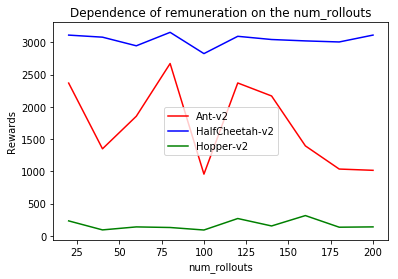

In [10]:
plt.plot(ant_rewards["x"], ant_rewards["rewards"], 'r', label='Ant-v2')
plt.plot(half_cheetah_rewards["x"], half_cheetah_rewards["rewards"], 'b', label='HalfCheetah-v2')
plt.plot(hopper_rewards["x"], hopper_rewards["rewards"], 'g', label='Hopper-v2')
plt.title('Dependence of remuneration on the num_rollouts')
plt.xlabel('num_rollouts')
plt.ylabel('Rewards')
plt.legend()
plt.show()

Как видно из графиков для более простых моделей достаточно небольшого количества набранной статистики, в то время как для более сложных требуется моделей требуется больше статистики и больше шагов, хотя для модели Ant-v2 слишком большое количество статистики так же было не в пользу.

Так же из данного графика видно, что архитектура хорошо подходит для __HalfCheetah__, но совсем не подходит для __Hooper__.

***
__Задание 1.2.__ Выберите несколько гиперапараметров вашей модели, которые влияют на качество обучения (количество эпох, количество слоев и т.п.). Для одного из окружений постройте графики влияния значений этих параметров на качество обучения (totalr).

### В качестве окружения используется HalfCheetah

In [9]:
def test_model_with_parameters(parameter, values):
    ''' Тестирования качества обучения модели от заданного параметра '''
    
    rewards = []
    for (i, value) in enumerate(values):
        display.clear_output()
        print(parameter)
        print("[" + str(i+1) + " : " + str(len(values)) + "]\t Value = " + str(value) + "\n")
        
        # использование соответствующего параметра
        if (parameter == "Epochs"):
            testing_model = BC_Model(x, y)
            testing_model.train(epochs=value)
        elif(parameter == "Dropout rates"):
            testing_model = BC_Model(x, y, dropout_rate=value)
            testing_model.train()
        elif(parameter == "Numbers of hidden layers"):
            testing_model = BC_Model(x, y, num_of_hid_layers=value)
            testing_model.train()
        elif(parameter == "Sizes of hidden layers"):
            testing_model = BC_Model(x, y, hid_layer_size=value)
            testing_model.train()
        
        # расчитываем среднюю награду с заданным параметром 
        total_rewards = test_model(testing_model)
        rewards.append(np.mean(total_rewards))
    
    return {"parameter": parameter, "rewards": rewards, "x": values}
    

In [10]:
def draw_graph(res_rewards, plot):
    ''' Вывод графика зависимости качества обучения от параметра на экран '''
    
    plot.plot(res_rewards["x"], res_rewards["rewards"], 'b', label='Mean reward')
    plot.set_title('Rewards and ' + str(res_rewards["parameter"]))
    plot.set_xlabel(str(res_rewards["parameter"]))
    plot.set_ylabel('Rewards')

## Зависимость качества обучения
### От эпох

In [11]:
epochs_rewards = test_model_with_parameters("Epochs", [i for i in np.arange(50, 601, 50)])

Epochs
[12 : 12]	 Value = 600

Training...



Testing...


### От dropout

In [12]:
dropout_rates_rewards = test_model_with_parameters("Dropout rates", [0.1, 0.2, 0.3, 0.4, 0.5])

Dropout rates
[5 : 5]	 Value = 0.5

Training...



Testing...


### От числа скрытых слоев

In [16]:
num_of_hid_layers_rewards = test_model_with_parameters("Numbers of hidden layers", [1, 2, 3, 4, 5, 6, 7, 8, 9])

Numbers of hidden layers
[9 : 9]	 Value = 9

Training...



Testing...


### От размеров скрытых слоев

In [14]:
sizes_of_hid_layers_rewards = test_model_with_parameters("Sizes of hidden layers",  [32, 64, 128, 256, 512, 1024])

Sizes of hidden layers
[6 : 6]	 Value = 1024

Training...



Testing...


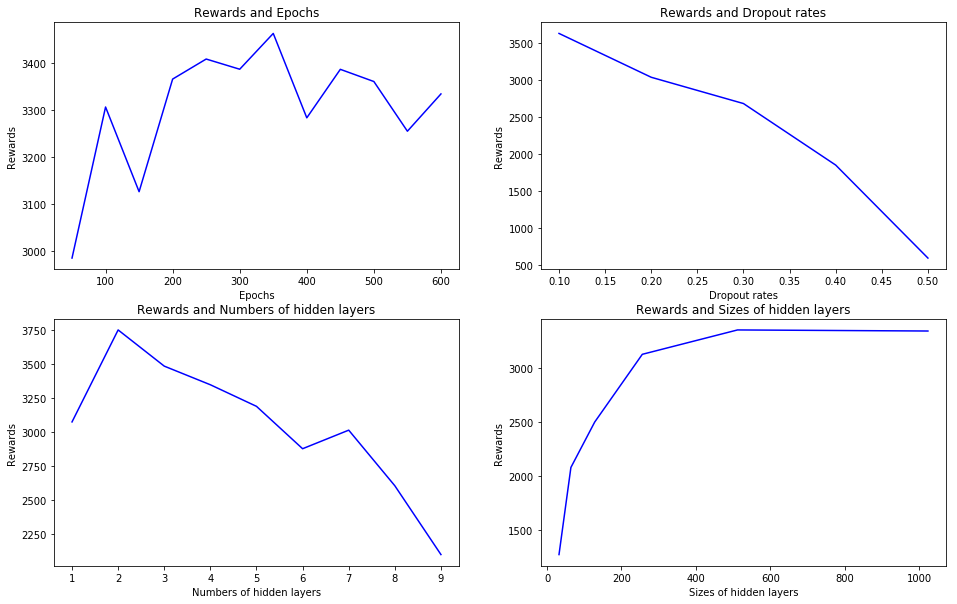

In [17]:
# вывод графиков зависимости качества модели от заданных параметров
_, axes = plt.subplots(2, 2, figsize=(16, 10))
draw_graph(epochs_rewards, axes[0][0])
draw_graph(dropout_rates_rewards, axes[0][1])
draw_graph(num_of_hid_layers_rewards, axes[1][0])
draw_graph(sizes_of_hid_layers_rewards, axes[1][1])
plt.show()

На основе графиков видно, что для модели __HalfCheetah__ наиболее оптимальные параметры:
 * __200 эпох на обучение__, при большем числе эпох модель не сильно улучшается в качестве, но может переобучиться;
 * __dropout <= 0.2__, так как сильно уменьшает скорость обучения и может ухудшить качество модели;
 * __2-3 полносвязных скрытых слоя__;
 * __256-512 нейронов на скрытых слоях__.
 
Для каждого окружения (enviroment) необходимо подбирать наиболее оптимальные параметры. Данные проверки относятся только к __HalfCheetan__.

### Обучим модель HalfCheetah с оптимальными параметрами

In [20]:
cloner2 = BC_Model(x, y, dropout_rate = 0.2, hid_layer_size = 256, num_of_hid_layers = 3)
cloner2.train(epochs=200)
total_rewards = test_model(cloner2)
print('mean return', np.mean(total_rewards))
print('std of return', np.std(total_rewards))

Training...



Testing...



mean return 3774.4280839447006
std of return 130.7513262295433


Среднее качества модели значительно больше экспертной (3774 > 710) , даже учитывая немного большую дисперсию.

***
## 2. DAgger Algorithm

Цель алгоритма DAgger (data Aggregation) - собрать статистику обучаемой модели, вместо экспертных данных. 
- Вначале мы тренируем BC_Model на собранных экспертных данных.
- Запускаем модель на окружениие, собираем наблюдения.
- Затем мы просим эксперта (человека) отметить, какие действия нужно совершать в полученных наблюдениях (по сути используем __policy_fn__).
- Создаем новую коллекцию помеченных и экспертных данных.
- Потворяем.

![image.png](dagger.png)

In [12]:
with tf.Session():
    DAgger_iter = 30
    render = False
    # цикл алгоритма DAgger 
    for i in tqdm_notebook(range(DAgger_iter)):
        # инициализация на каждой итерации
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        # собираем данные модели и эксперта
        while not done:
            ### Ваш код здесь - получаем действие, используя обученную модель
            action = cloner.sample(obs)

            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            # получаем экспертное действия для того же входа 
            ### Ваш код здесь - испольузуем policy_fn
            # corrected_action = 
            corrected_action = policy_fn(obs[None, :])

            # добавляем наблюдение и действие эксперта в набор данных
            new_obs.append(obs)
            new_actions.append(corrected_action)
        # переупорядочиваем данные
        x = np.concatenate((x, obs[None, :]), axis=0)
        y = np.concatenate((y, corrected_action[None, :]), axis=0)
        ### Ваш код здесь - дообучаем модель на обновленных данных
        cloner.train(train_data=x, test_data=y)

### Проверяем работу

In [15]:
num_eval_rollouts = 20
# итерация по rollouts
returns = []
for i in range(num_eval_rollouts):
    # инициализация
    totalr = 0
    done = False
    obs = env.reset()
    # цикл до конца эпизода
    while not done:
        # получаем действие от обученной модели
        action = cloner.sample(obs)
        # применяем действие в среде
        obs, r, done, _ = env.step(action)
        env.render()
        totalr += r
    returns.append(totalr)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))


mean return 1602.6001610694427
std of return 229.78268946196587


__Задание 2.1.__ Проверьте работу DAagger на всех задачах MuJoco - укажите для какой задачи он работает лучше, чем простое клонирование. Покажите это на графиках.

In [6]:
def test_model_with_DAgger(env_name):
    display.clear_output()
    print(env_name)
    
    x, y = generate_data()
    testing_model = BC_Model(x, y)
    testing_model.train()
    total_reward = np.mean(test_model(testing_model))
    
    # дообучаем модель с алгоритмом DAgger
    with tf.Session():
        for i in range(20):
            new_obs = []
            new_actions = []
            obs = env.reset()
            done = False
            while not done:
                action = testing_model.sample(obs)
                obs, _, done, _ = env.step(action)
                corrected_action = policy_fn(obs[None, :])
                new_obs.append(obs)
                new_actions.append(corrected_action)
            x = np.concatenate((x, obs[None, :]), axis=0)
            y = np.concatenate((y, corrected_action[None, :]), axis=0)
            testing_model.train(train_data=x, test_data=y, epochs=20)
    
    da_total_reward = np.mean(test_model(testing_model))
    return {"reward": total_reward, "DA reward": da_total_reward}

In [8]:
# В коде используются глобальные переменные окружения, поэтому копипаст...

### Humanoid-v2
# генерируем окружение
env_name="Humanoid-v2"
expert_policy_file = "experts/" + env_name + ".pkl"
# загружеаем стратегию
policy_fn = load_policy.load_policy(expert_policy_file)
# создаем окружение
env = gym.make(env_name)
# очищаем состояние окружения
env.reset()

# получаем rewards
humanoid_rewards = test_model_with_DAgger(env_name)
# закрываем окружение
env.close()
# PS: в документации написано, что так же закрывает все используемые окна,
# но окна mujoco по прежнему не закрываются (возможно исправят в будующем)


### Ant-v2
env_name="Ant-v2"
expert_policy_file = "experts/" + env_name + ".pkl"
policy_fn = load_policy.load_policy(expert_policy_file)
env = gym.make(env_name)
env.reset()

ant_rewards = test_model_with_DAgger(env_name)
env.close()


### HalfCheetah-v2
env_name="HalfCheetah-v2"
expert_policy_file = "experts/" + env_name + ".pkl"
policy_fn = load_policy.load_policy(expert_policy_file)
env = gym.make(env_name)
env.reset()

half_cheetah_rewards = test_model_with_DAgger(env_name)
env.close()


### Hopper-v2
env_name="Hopper-v2"
expert_policy_file = "experts/" + env_name + ".pkl"
policy_fn = load_policy.load_policy(expert_policy_file)
env = gym.make(env_name)
env.reset()

hopper_rewards = test_model_with_DAgger(env_name)
env.close()


### Reacher-v2
env_name="Reacher-v2"
expert_policy_file = "experts/" + env_name + ".pkl"
policy_fn = load_policy.load_policy(expert_policy_file)
env = gym.make(env_name)
env.reset()

reacher_rewards = test_model_with_DAgger(env_name)
env.close()


### Walker2d-v2
env_name="Walker2d-v2"
expert_policy_file = "experts/" + env_name + ".pkl"
policy_fn = load_policy.load_policy(expert_policy_file)
env = gym.make(env_name)
env.reset()

walker2d_rewards = test_model_with_DAgger(env_name)
env.close()

Walker2d-v2
mean return 686.74957736026
std of return 5.792500019566628
dimension of obs : (4000, 17)
dimension of actions : (4000, 1, 6)
Training...



Testing...


Creating window glfw

Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Training...



Testing...


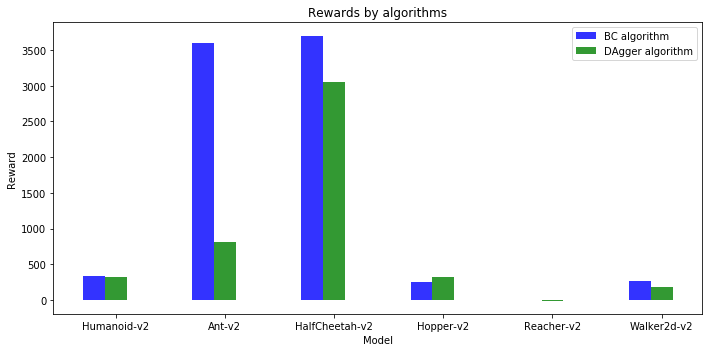

In [14]:
# записываем данные по качествам моделей для обоих алгоритмов
n_groups = 6
bc_alg = (humanoid_rewards["reward"],
          ant_rewards["reward"],
          half_cheetah_rewards["reward"],
          hopper_rewards["reward"],
          reacher_rewards["reward"],
          walker2d_rewards["reward"])
DA_alg = (humanoid_rewards["DA reward"],
          ant_rewards["DA reward"],
          half_cheetah_rewards["DA reward"],
          hopper_rewards["DA reward"],
          reacher_rewards["DA reward"],
          walker2d_rewards["DA reward"])

# создаем plot и задаем параметры для графика
fig, ax = plt.subplots(figsize=(10, 5))
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8

# строим график для Behavioural cloning алгоритма
rects1 = plt.bar(index, bc_alg, bar_width,
alpha=opacity,
color='b',
label='BC algorithm')

# строим график для DAgger алгоритма
rects2 = plt.bar(index + bar_width, DA_alg, bar_width,
alpha=opacity,
color='g',
label='DAgger algorithm')

# задаем составляющие графика и отображаем его
plt.xlabel('Model')
plt.ylabel('Reward')
plt.title('Rewards by algorithms')
plt.xticks(index + bar_width, ('Humanoid-v2', 'Ant-v2', 'HalfCheetah-v2', 'Hopper-v2', 'Reacher-v2', 'Walker2d-v2'))
plt.legend()

plt.tight_layout()
plt.show()

Для окружений __Humanoid__, __Hooper__ и __Walker2d__ алгоритм __DAgger__ может улучшить модель, но для __Ant__ и __HalfCheetan__ лучше использовать только __BC__ алгоритм.

Как видно из графика построенная архитектура нейросети для моделей хорошо подходит только для __Ant__ и __HalfCheetah__. Так же на качество повлияло небольшое число собираемой статистики (roll-outs).

Для __Humanoid__ так же стоило бы увеличить максимальное число шагов (max_steps), так как 200 шагов недостаточно, чтобы собрать всю статистику